In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [8]:
from keras import models 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model
from keras.models import Sequential

# Load Data for SER

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

In [ ]:
len(paths)

In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

In [ ]:
df['label'].value_counts()

In [ ]:
sns.countplot(data=df, x='label')

# Load Data for FER

In [9]:
def getData(name):  
    main=os.listdir('/kaggle/input/fer2013/train')
    dic={}
    dir='/kaggle/input/fer2013/train'
    print(main)
    for i in main:
        initial_count = 0
        dirr=os.path.join(dir, i)
        for path in os.listdir(dirr):
            if os.path.isfile(os.path.join(dirr, path)):
                initial_count += 1
        dic[i]=initial_count
    courses = list(dic.keys())
    values = list(dic.values())
    fig = plt.figure(figsize = (10, 5))
    plt.bar(courses, values, color ='blue',
            width = 0.5)
    plt.savefig(f'fer2013_data_info_face_dataset')

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


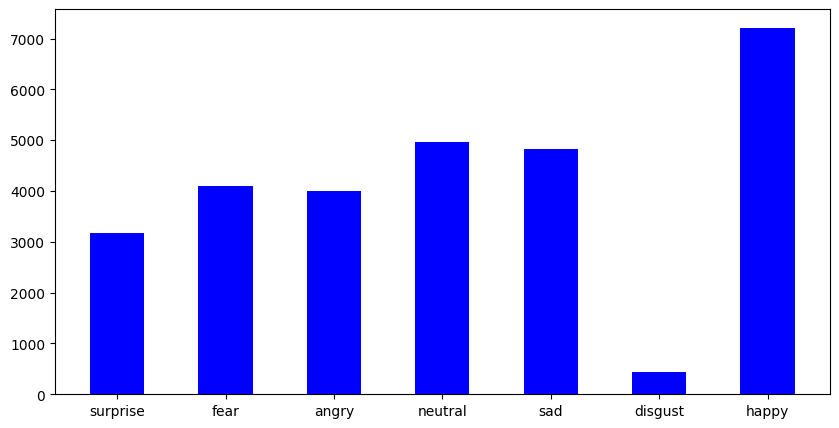

In [5]:
getData('train')

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


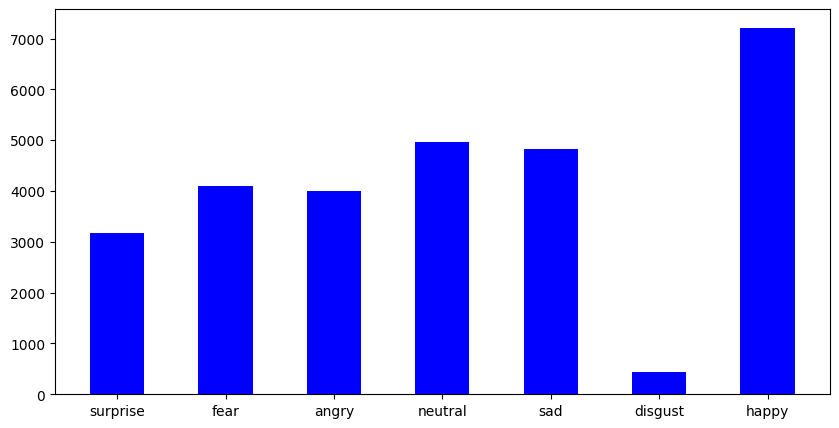

In [5]:
getData('test')

# Feature Extraction (SER)

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['speech'][0])

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)X_mfcc

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

In [ ]:
X = np.expand_dims(X, -1)
X.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

# Preparing the Test and Validation Test (FER)

In [4]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(100,100),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(100,100),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Creating SER model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Creating The FER model

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def get_model(input_size, classes=7):
    model = Sequential()   
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

classes = 7
my_model = get_model((100, 100, 1), classes)

my_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,950,919 (26.52 MB)

 Trainable params: 6,950,279 (26.51 MB)

 Non-trainable params: 640 (2.50 KB)

In [8]:
classes=7
my_model = get_model((100,100,1), classes)
my_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,950,919 (26.52 MB)

 Trainable params: 6,950,279 (26.51 MB)

 Non-trainable params: 640 (2.50 KB)

# Training SER model and Saving it

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)
from keras.models import Model

model.save('my_modelser.h5')  

# Training FER model and Saving it

In [10]:
steps_per_epoch = 64  
validation_steps = 64  

hist = my_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

my_model.save('my_modelfer.h5')

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.5721 - loss: 1.2714 - val_accuracy: 0.5579 - val_loss: 1.3302
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.5560 - loss: 1.3398 - val_accuracy: 0.5724 - val_loss: 1.2813
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.5412 - loss: 1.3485 - val_accuracy: 0.5444 - val_loss: 1.3786
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5496 - loss: 1.3456 - val_accuracy: 0.5616 - val_loss: 1.3111
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.5691 - loss: 1.3118 - val_accuracy: 0.5623 - val_loss: 1.2953
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.5682 - loss: 1.2801 - val_accuracy: 0.5652 - val_loss: 1.2969
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5653 - loss: 1.2903 - val_accuracy: 0.5850 - val_loss: 1.2468
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5156 - loss: 1.4019 - val_acc

# SER accuracy graph

In [ ]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# FER Accuracy Graph

In [11]:
train_loss, train_accu = my_model.evaluate(training_set)
test_loss, test_accu = my_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.6558 - loss: 1.0232
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6222 - loss: 1.1079
final train accuracy = 65.19 , validation accuracy = 61.21


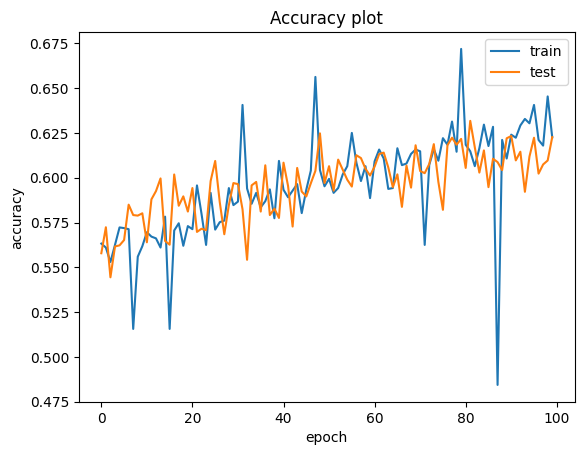

In [12]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")

# **Load Model for faster access**

In [10]:
my_modelser = tf.keras.models.load_model('my_modelser.h5')
my_modelfer = tf.keras.models.load_model('my_modelfer.h5')

# **Print Confusion Matrix to know Accuracy for FER**

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = my_model.predict(test_set)
rounded_predictions = np.argmax(predictions, axis=-1)
test_labels = test_set.labels
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


## **Testing OpenCV for use (For FER)**

In [ ]:
frame = cv2.imread('/kaggle/opencv.png')
plt.imshow(frame)

In [ ]:
frame = cv2.imread('/kaggle/test/test_face.jpeg')

In [ ]:
frame.shape

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

In [ ]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
    face_roi = roi_color[ey: ey+eh, ex:ex+ew]

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB ))

# Using Model for Speech emotion recognition

In [ ]:
def extract_mfcc(audio_path):
    y, sr = librosa.load(audio_path, duration=3, offset=0.5)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfccs.reshape(1, -1, 1)

from keras.models import load_model

model = load_model('/kaggle/working/my_modelser.h5')  



audio_file = '/kaggle/input/paudio/audio_2.wav'  

mfccs = extract_mfcc(audio_file)

prediction = model.predict(mfccs)

emotion_index = np.argmax(prediction)
emotions = ['anger', 'unknown_emotion', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_Suprise', 'sad']
predicted_emotion = emotions[emotion_index]

print("Predicted emotion:", predicted_emotion)

# Using model for face emotion recognition

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
disgust


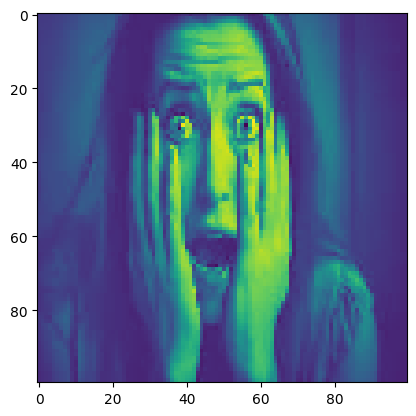

In [15]:
from tensorflow.keras.preprocessing import image
dir_path='/kaggle/input/predict1'
for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'//'+i, target_size=(100,100), color_mode="grayscale")
    plt.imshow(img);
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis = 0)
    X = X/255
    images = np.vstack([X])
    val=my_modelfer.predict(images)
    if (np.argmax(val[0]) == 0):
        print("Suprise")
    elif(np.argmax(val[0])==1):
        print("fear")
    elif(np.argmax(val[0])==2):
        print("angry")
    elif(np.argmax(val[0])==3):
        print("neutral")
    elif(np.argmax(val[0])==4):
        print("sad")
    elif(np.argmax(val[0])==5):
        print("disgust")
    elif(np.argmax(val[0])==6):
        print("happy")

# **Predicting Facial Emotion Using Webcam**

In [16]:
path = 'haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN
rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text = ""
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
text_offset_x = 10
text_offset_y = img.shape[0] -25
box_coords = ((text_offset_x, text_offset_y), (text_offset_x+text_width+2, text_offset_y-text_height-2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
font = cv2.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
color = (255, 0, 0)
thickness = 2
cv2.putText(img, 'OpenCV', org, font, fontScale, color, thickness, cv2.LINE_AA)
face_roi = None

In [18]:
vid = cv2.VideoCapture(0)

[ WARN:0@1863.220] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1863.220] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


In [19]:
while(True):
    ret, frame = vid.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = gray[y:y+h, x:x+w]
        cv2.rectangle(gray, (x,y), (x+w, y+h), (255,0,0),2)
        face_roi = roi_color
    if(face_roi is not None):
        image = cv2.resize(face_roi, (100,100))
        X = np.expand_dims(image, axis = 0)
        X = X/255
        images = np.vstack([X])
        val=my_model.predict(images)
        prediction_value = np.argmax(val[0])
        if(prediction_value == 0):
            status = "Angry"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 1):
            status = "Disgust"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 2):
            status = "Fear"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 3):
            status = "Happy"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 4):
            status = "Neutral"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 5):
            status = "Sad"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 6):
            status = "Suprised"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
    cv2.imshow('Face Emotion Recognition', gray)
    if(cv2.waitKey(2) & 0xFF == ord('q')):
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()  

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
